# SED fitting using eazy-py on the SPHEREx yarn cluster

### install eazy-py from https://github.com/gbrammer/eazy-py
- For templates and filters, https://github.com/gbrammer/eazy-photoz/

### what you need: 
- `premade-tempfilt.pickle` : sed-fit-grid which has all of filters and templates information

### what `ez` is: 
> `inputcatalog in csv` + `premade-tempfilt` + `param` <br> 

### make a table with the columns, 

- `filename` 
- `sizemb` 

## Basic Packages

In [1]:
#!pip list |grep pyarrow

In [2]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import numpy as np
from astropy.table import Table
from matplotlib.ticker import MultipleLocator
import pandas as pd

from astropy.utils.exceptions import AstropyWarning
import warnings

pd.set_option('display.max_rows', 300)
    
np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

# https://github.com/gbrammer/eazy-py
import eazy

In [3]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py
#from netCDF4 import Dataset
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pq

from functools import reduce
import operator
import gc

In [4]:
# plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [5]:
!pip list |grep eazy

/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
eazy                      0.6.8               


## PySpark Sessions

In [6]:
%%time
# PySpark packages
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W


spark = SparkSession.builder \
    .master("yarn") \
    .appName("spark-shell") \
    .config("spark.driver.maxResultSize", "32g") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "7g") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "20") \
    .getOrCreate()


sc = spark.sparkContext
sc.setCheckpointDir("hdfs://spark00:54310/tmp/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

CPU times: user 9.01 ms, sys: 9.81 ms, total: 18.8 ms
Wall time: 32.5 s


## Input Files

### Hadoop File System

In [7]:
hdfsheader = 'hdfs://spark00:54310'

In [8]:
datapath = '/user/yyang/external-catalogs/raw/refcat/original/'

In [9]:
outlist = !hdfs dfs -ls /user/yyang/external-catalogs/raw/refcat/original/ | \
awk '{gsub(".*/", "", $NF); print $NF, $5/1024/1024}'

In [10]:
outlist[1:5]

['Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000000.parquet 61.2986',
 'Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000001.parquet 53.6759',
 'Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000002.parquet 65.8121',
 'Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000003.parquet 54.4145']

In [11]:
[datapath+line for line in outlist[1:5]]

['/user/yyang/external-catalogs/raw/refcat/original/Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000000.parquet 61.2986',
 '/user/yyang/external-catalogs/raw/refcat/original/Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000001.parquet 53.6759',
 '/user/yyang/external-catalogs/raw/refcat/original/Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000002.parquet 65.8121',
 '/user/yyang/external-catalogs/raw/refcat/original/Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000003.parquet 54.4145']

#### make a spark dataframe for this catalog file list

In [12]:
sdf = spark.createDataFrame([x.split(' ') for x in outlist[1:]], ['name', 'size'])

In [13]:
sdf = sdf.withColumn("size", sdf["size"].cast(T.DoubleType()))

In [14]:
sdf.printSchema()

root
 |-- name: string (nullable = true)
 |-- size: double (nullable = true)



In [15]:
sdf.show(5, truncate=True)

+--------------------+-------+
|                name|   size|
+--------------------+-------+
|Gaia_DR3.LS.PS1DR...|61.2986|
|Gaia_DR3.LS.PS1DR...|53.6759|
|Gaia_DR3.LS.PS1DR...|65.8121|
|Gaia_DR3.LS.PS1DR...|54.4145|
|Gaia_DR3.LS.PS1DR...|49.1311|
+--------------------+-------+
only showing top 5 rows



In [16]:
sdfrank = sdf.withColumn("irank", F.rank().over(W.orderBy("size")))

In [17]:
sdfrank.show(5, truncate=True)

+--------------------+-------+-----+
|                name|   size|irank|
+--------------------+-------+-----+
|Gaia_DR3.LS.PS1DR...|18.7712|    1|
|Gaia_DR3.LS.PS1DR...|19.4544|    2|
|Gaia_DR3.LS.PS1DR...|20.1404|    3|
|Gaia_DR3.LS.PS1DR...|20.6769|    4|
|Gaia_DR3.LS.PS1DR...|20.8368|    5|
+--------------------+-------+-----+
only showing top 5 rows



In [18]:
sdfrank.orderBy("size").show(5, truncate=True)

+--------------------+-------+-----+
|                name|   size|irank|
+--------------------+-------+-----+
|Gaia_DR3.LS.PS1DR...|18.7712|    1|
|Gaia_DR3.LS.PS1DR...|19.4544|    2|
|Gaia_DR3.LS.PS1DR...|20.1404|    3|
|Gaia_DR3.LS.PS1DR...|20.6769|    4|
|Gaia_DR3.LS.PS1DR...|20.8368|    5|
+--------------------+-------+-----+
only showing top 5 rows



#### save this parquet in my hdfs directory

In [19]:
workpath = '/user/shong/work/sedfit/spherex/data/temp/'

In [20]:
hdfsheader+workpath+'refcat-list.parquet.snappy'

'hdfs://spark00:54310/user/shong/work/sedfit/spherex/data/temp/refcat-list.parquet.snappy'

In [21]:
sdfrank.orderBy("size").write.option("compression", "snappy") \
.mode("overwrite") \
.parquet(hdfsheader+workpath+'refcat-list.parquet.snappy')

In [22]:
!hdfs dfs -ls {hdfsheader+workpath}

Found 1 items
drwxr-xr-x   - shong supergroup          0 2024-03-19 15:07 hdfs://spark00:54310/user/shong/work/sedfit/spherex/data/temp/refcat-list.parquet.snappy


### Read the saved list-dataframe and do some statistics for planning sed caculations

In [23]:
df = spark.read.parquet("hdfs://spark00:54310/user/shong/work/sedfit/spherex/data/temp/refcat-list.parquet.snappy")

In [24]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- size: double (nullable = true)
 |-- irank: integer (nullable = true)



In [25]:
df.show(3,truncate=True)

+--------------------+-------+-----+
|                name|   size|irank|
+--------------------+-------+-----+
|Gaia_DR3.LS.PS1DR...|18.7712|    1|
|Gaia_DR3.LS.PS1DR...|19.4544|    2|
|Gaia_DR3.LS.PS1DR...|20.1404|    3|
+--------------------+-------+-----+
only showing top 3 rows



#### `toPandas()`

In [26]:
pdf = df.toPandas()

In [27]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12288 entries, 0 to 12287
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    12288 non-null  object 
 1   size    12288 non-null  float64
 2   irank   12288 non-null  int32  
dtypes: float64(1), int32(1), object(1)
memory usage: 240.1+ KB


In [28]:
pdf.head()

,name,size,irank
0,Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE...,18.7712,1
1,Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE...,19.4544,2
2,Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE...,20.1404,3
3,Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE...,20.6769,4
4,Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE...,20.8368,5


In [29]:
pdf.tail()

,name,size,irank
12283,Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE...,559.985,12284
12284,Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE...,561.910,12285
12285,Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE...,566.999,12286
12286,Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE...,570.862,12287
12287,Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE...,572.447,12288


In [30]:
pdf["size"].describe()

count    12288.000000
mean        72.990726
std         52.957251
min         18.771200
25%         50.088500
50%         60.941500
75%         74.298100
max        572.447000
Name: size, dtype: float64

#### Histogram of the file size distribution

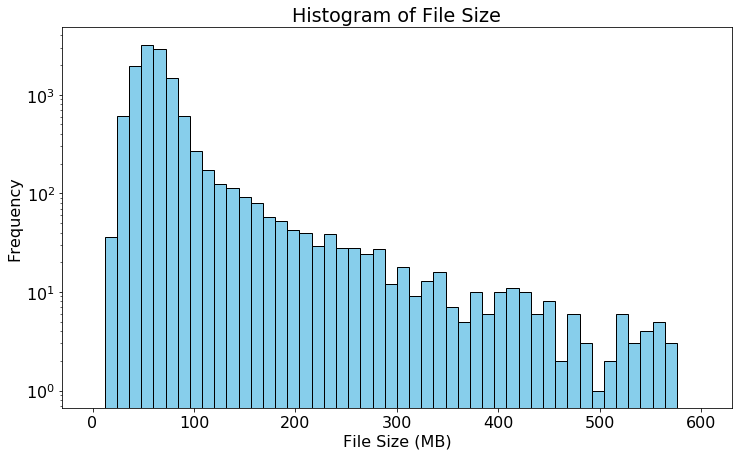

In [31]:
fig = plt.figure(figsize=(12,7))

# Assuming df is your pandas DataFrame containing the 'size' column
plt.hist(pdf['size'], bins=50, range=(0,600), color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('File Size (MB)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of File Size')

plt.show()

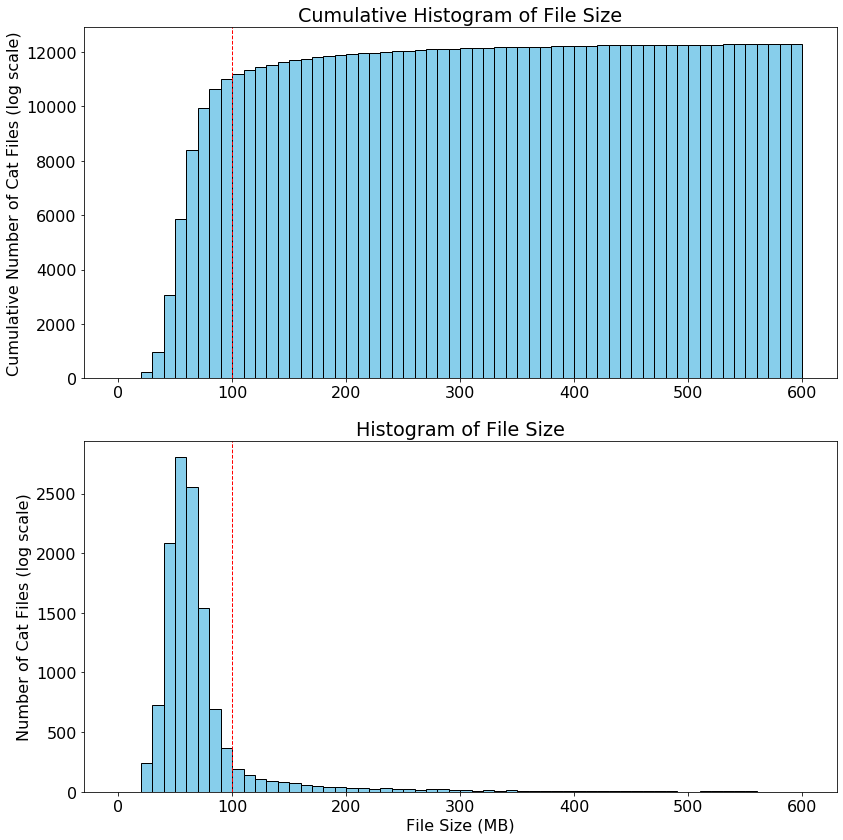

In [32]:
# Set the minimum and maximum values for the x-axis
x_min = 0
x_max = 600  # Adjust this value according to your data

# Create a figure with two subplots vertically arranged
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plot the second histogram (cumulative frequency histogram)
axs[0].hist(pdf['size'], bins=60, range=(x_min, x_max), cumulative=True, color='skyblue', edgecolor='black')
axs[0].set_title('Cumulative Histogram of File Size')
axs[0].set_ylabel('Cumulative Number of Cat Files (log scale)')

# Plot the vertical line at size=100 for the first histogram
axs[0].axvline(x=100, color='red', linestyle='dashed', linewidth=1)

# Plot the first histogram (frequency histogram)
axs[1].hist(pdf['size'], bins=60, range=(x_min, x_max), color='skyblue', edgecolor='black')
#axs[1].set_yscale('log')  # Set y-axis to log scale
axs[1].set_title('Histogram of File Size')
axs[1].set_ylabel('Number of Cat Files (log scale)')
# Plot the vertical line at size=100 for the first histogram
axs[1].axvline(x=100, color='red', linestyle='dashed', linewidth=1)
axs[1].set_xlabel('File Size (MB)')

# Adjust layout
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('catfile_stats.png')

# Show the plot
plt.show()

> Most of 11k files are less than 100 MB. Hence, our running time should be determined by the performance on these 11k small catalog files. 